In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('../Prepared_Data/data.csv')

In [2]:
##### Set the Plot Sheme #####
import tueplots
from tueplots import bundles

# this provides the color palette of Uni Tuebingen
from tueplots.constants.color import rgb
# e.g. as rgb.tue_blue, rgb.tue_red, etc.

# set plotting stylesheet
#plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=2, usetex=False))

In [3]:
##### Cluster data #####

# remove rows that have values missing
data = data.dropna()

# calculate correlation between 'year' and each complexity factor
correlation_with_year = data[['year', 'number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                                   'number_of_categories', 'number_of_unique_parts', 'number_of_different_parts',
                                   'not_unique_parts', 'proportion_unique_to_not_unique']].corr()['year']


print(correlation_with_year)

# select relevant columns for clustering
columns_for_clustering = ['number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                           'number_of_categories', 'number_of_unique_parts',
                           'number_of_different_parts', 'not_unique_parts',
                           'proportion_unique_to_not_unique']

# extract the selected columns for clustering
data_for_clustering = data[columns_for_clustering]

# impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
data_for_clustering_imputed = imputer.fit_transform(data_for_clustering)

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering_imputed)

# determine the optimal number of clusters using the elbow method
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

year                               1.000000
number_of_parts                    0.167349
minifig_quantitiy                  0.142818
number_of_colors                   0.390034
number_of_categories               0.306093
number_of_unique_parts             0.265063
number_of_different_parts          0.229051
not_unique_parts                   0.156939
proportion_unique_to_not_unique    0.043316
Name: year, dtype: float64


c:\users\edwar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\users\edwar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\users\edwar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\users\edwar\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_

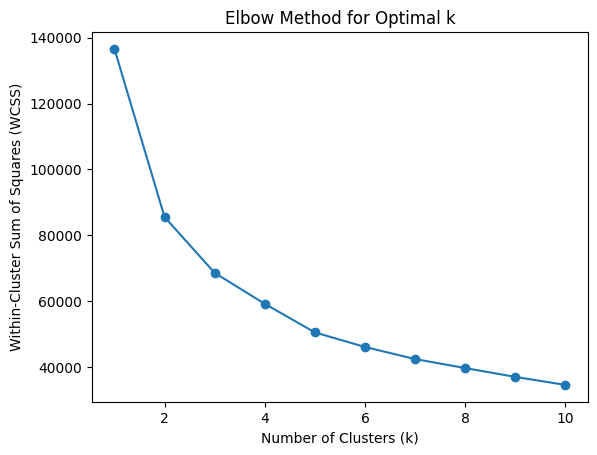

c:\users\edwar\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


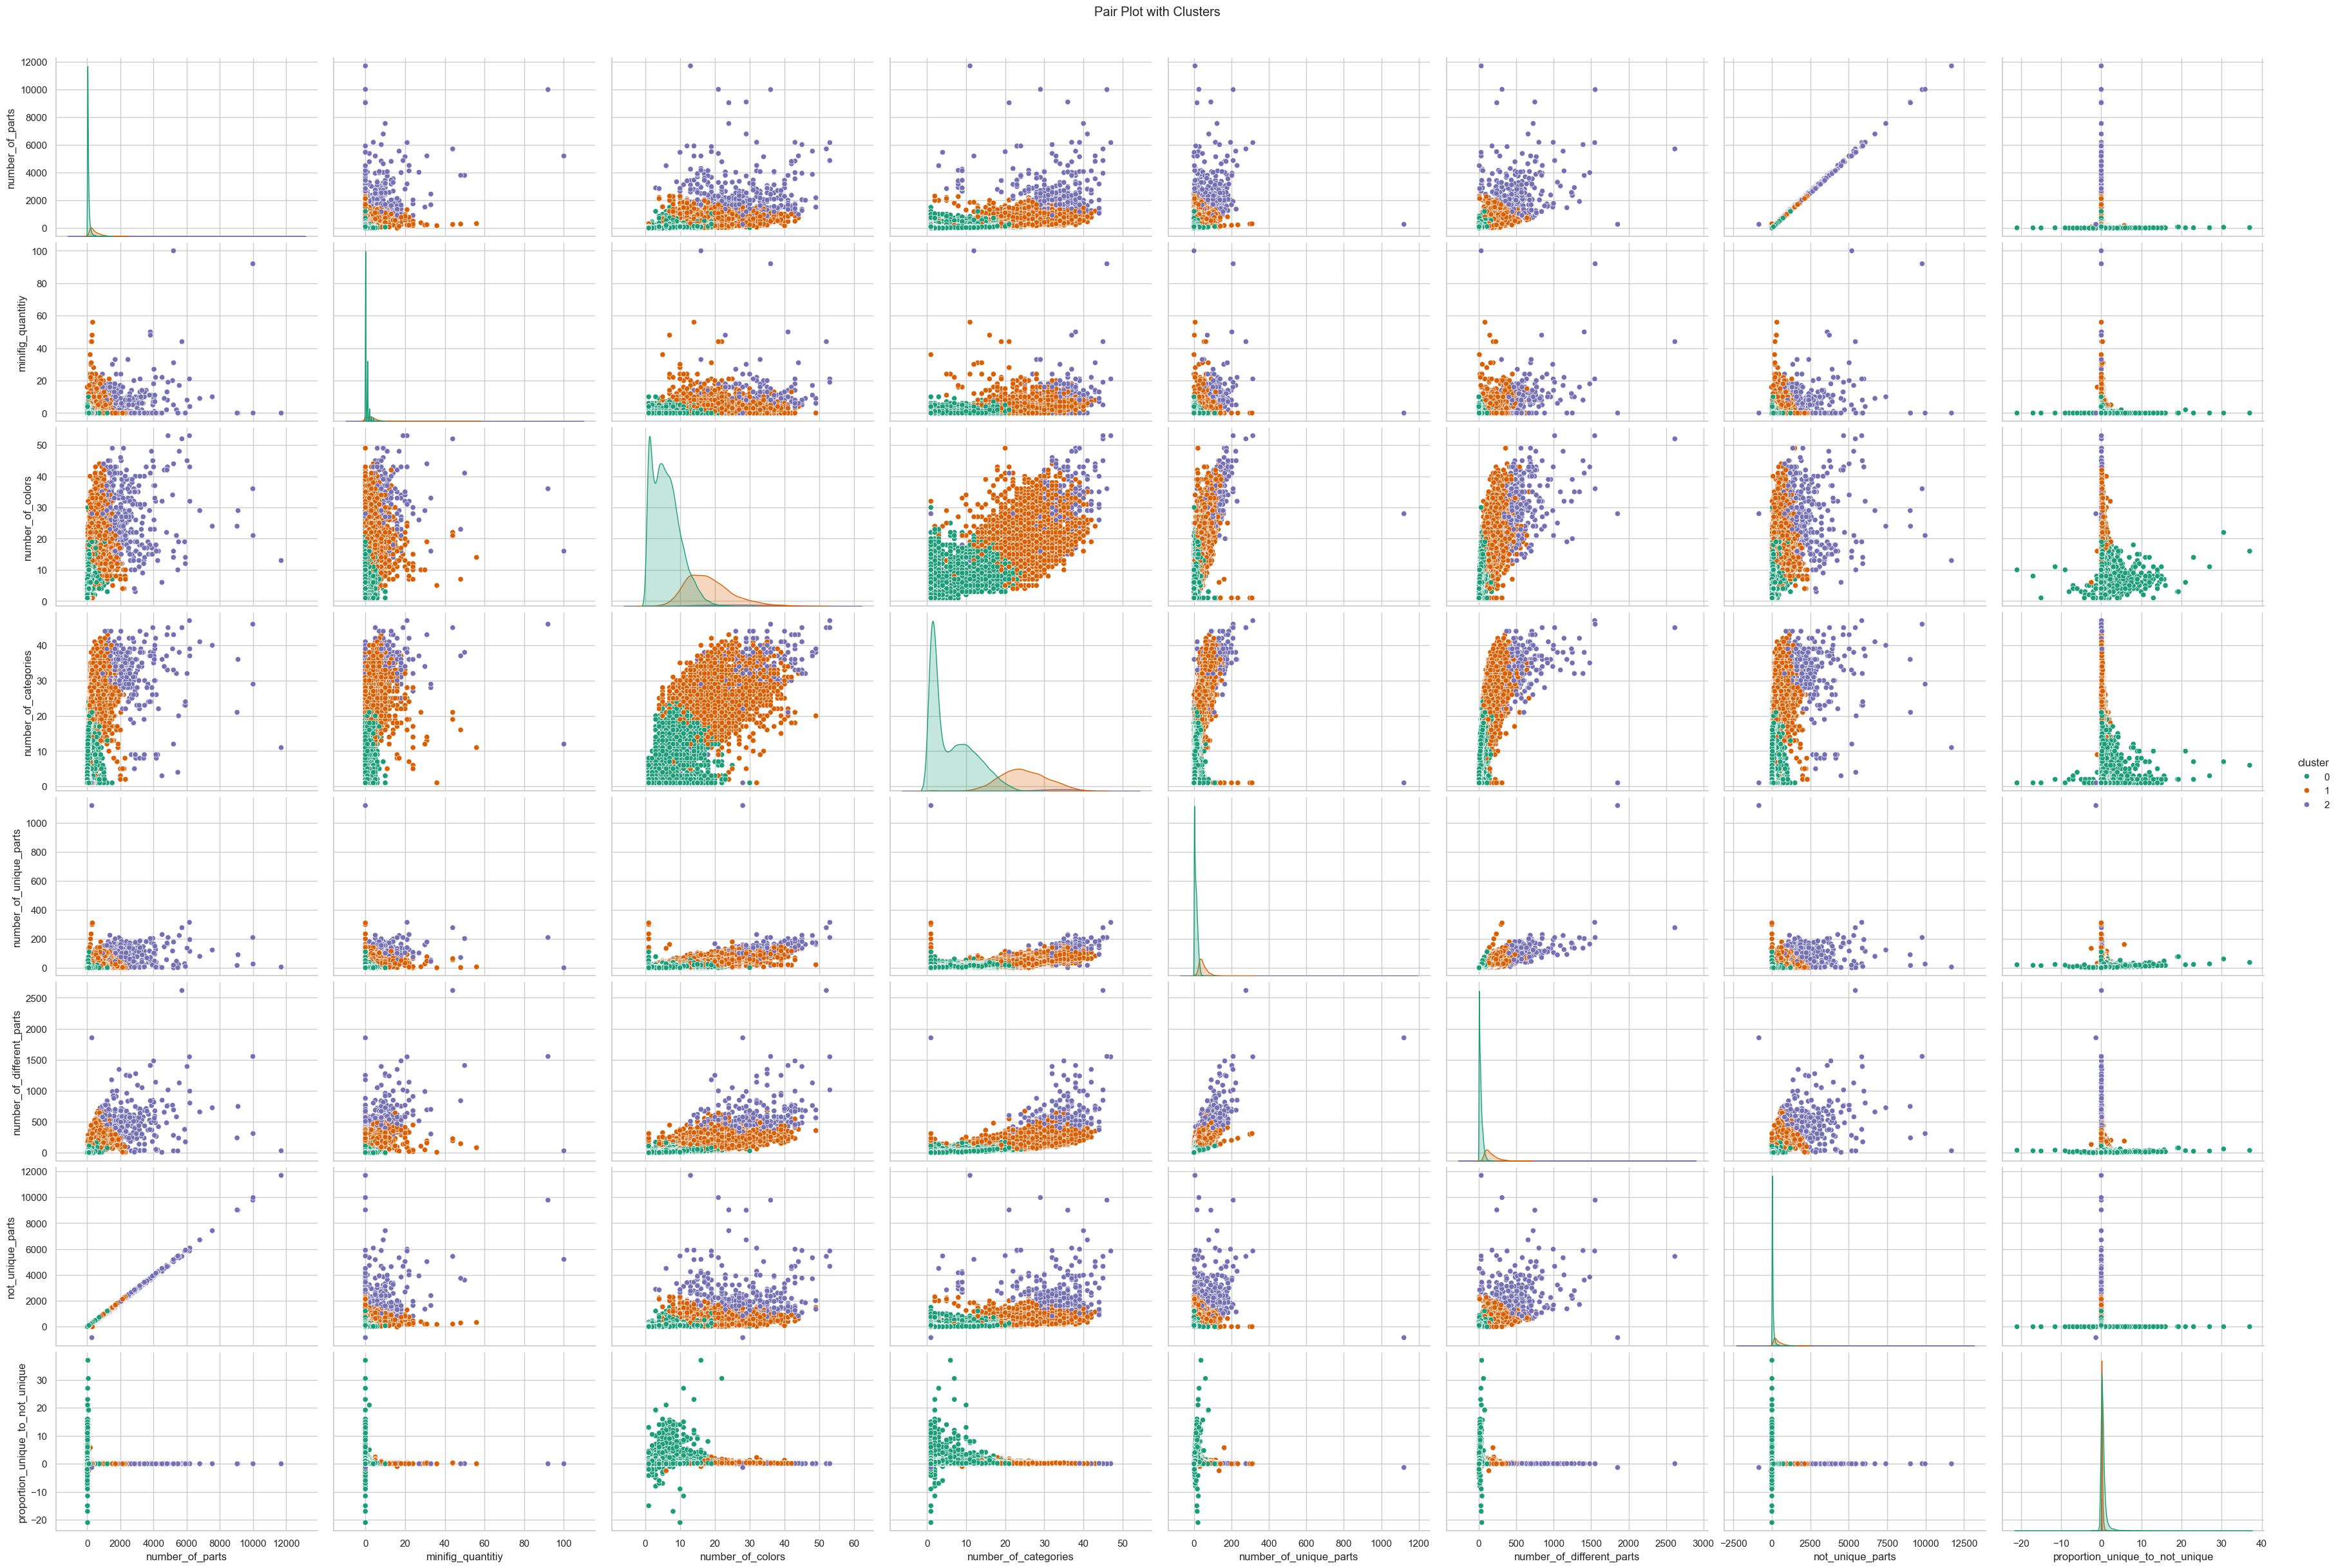

In [4]:
##### Plot the elbow method graph #####

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

# Based on the elbow method, choose the optimal number of clusters
optimal_k = 3  # You can change this based on the plot

# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add the cluster labels to the original DataFrame
data['cluster'] = clusters

# Visualize the clusters using a pair plot
sns.set(style="whitegrid")
sns.pairplot(data, hue='cluster', palette='Dark2', vars=columns_for_clustering, height=3, aspect=1.5)
plt.suptitle('Pair Plot with Clusters', y=1.02)
plt.show()

In [5]:
##### Print means of different factors in the clusters #####

# select only numeric columns for aggregation
numeric_columns = ['number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                    'number_of_categories', 'number_of_unique_parts',
                    'number_of_different_parts', 'not_unique_parts',
                    'proportion_unique_to_not_unique', 'complexity_score']

# ensure numeric columns have the correct data types (convert if necessary)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# drop rows with missing values
df = data.dropna(subset=numeric_columns)

# group by cluster and calculate mean for numeric columns
cluster_means = data.groupby('cluster')[numeric_columns].mean()

# display the cluster means
print(cluster_means)

         number_of_parts  minifig_quantitiy  number_of_colors  \
cluster                                                         
0              62.952691           0.475631          6.056993   
1             463.227087           3.252345         18.147943   
2            2574.987578           7.602484         27.413043   

         number_of_categories  number_of_unique_parts  \
cluster                                                 
0                    6.442134                9.517146   
1                   24.580707               47.147943   
2                   32.052795               96.636646   

         number_of_different_parts  not_unique_parts  \
cluster                                                
0                        23.235672         53.435545   
1                       159.547510        416.079144   
2                       512.841615       2478.350932   

         proportion_unique_to_not_unique  complexity_score  
cluster                                       

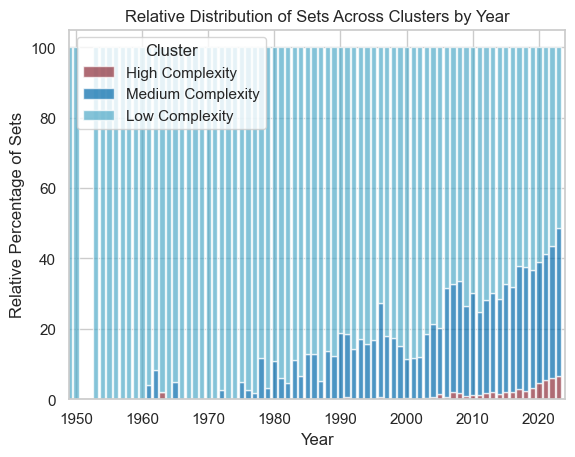

In [6]:
##### Plot the relative percentage of sets in each cluster for every year #####

# Group by year and cluster, and calculate the relative percentage
cluster_year_counts = df.groupby(['year', 'cluster']).size().reset_index(name='set_count')
cluster_year_counts['relative_percentage'] = (
    cluster_year_counts.groupby('year')['set_count'].transform(lambda x: x / x.sum()) * 100
)

# Pivot the DataFrame to have clusters as columns
pivot_df = cluster_year_counts.pivot(index='year', columns='cluster', values='relative_percentage').fillna(0)

# Create the figure and axes
fig, ax = plt.subplots(1,1)

# Plot the stacked bar plot using ax.bar
years = pivot_df.index
clusters_plot = pivot_df.columns
bottom_values = pd.Series(0, index=years)
colors = [rgb.tue_red, rgb.tue_blue, rgb.tue_lightblue]

cluster_labels = {
    0: 'Low Complexity',
    1: 'Medium Complexity',
    2: 'High Complexity'}

# Reverse the order of clusters
for cluster, color in zip(reversed(clusters_plot), colors):
    ax.bar(
        years,
        pivot_df[cluster],
        bottom=bottom_values,
        label=cluster_labels[cluster],
        alpha=0.7,
        color=color,
    )
    bottom_values += pivot_df[cluster]

ax.set_title('Relative Distribution of Sets Across Clusters by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Relative Percentage of Sets')
ax.set_xlim(1949, 2024)
ax.legend(title='Cluster')
plt.savefig('Clusters.pdf')
plt.show()
